# Data Wrangling: Getting and Cleaning Data, Creating Variables, and Preparing for Joins

## CalEnviroScreen4.0

Load data from CalEnviroScreen4.0

In [1]:
# Import os to change directory
import os
# Import pandas 
import pandas as pd
# Import geopandas
import geopandas as gpd
# Import numpy
import numpy as np
# Get mapping to crop raster with shapefile
from shapely.geometry import mapping
# Importing excel reader
import openpyxl

In [2]:
# Change directory to location of CalEnviroScreen data
os.chdir('Data/CalEnviroScreen')

In [5]:
# Load in CalEnviroScreen Data
esGdf = gpd.read_file('CES4 Final Shapefile.shp')

In [6]:
# Restrict census tracts to Riverside and San Bernardino Counties
esGdf_InlandEmpire = esGdf[esGdf['County'].isin(['Riverside', 'San Bernardino'])]

In [7]:
# Define disadvantaged communities as those with CalEnviroScreen score percentile ≥ 75
esGdf_InlandEmpire['CalEnviroScreen_EJ'] = esGdf_InlandEmpire['CIscoreP'].apply(lambda x: True if x >= 75 else False) 

/Users/clairebekker/anaconda3/envs/uds/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
#esGdf_InlandEmpire.columns

In [11]:
# Use only raw scores as x-variables
# List comprehension to exclude percentile columns and scores
cols_to_exclude = [col for col in esGdf_InlandEmpire.columns if col.endswith('P') or col.endswith('score') or col.endswith('Sc')
                   or col=='PollBurd' or col=='PopChar']
esGdf_InlandEmpire_rawscores = [col for col in esGdf_InlandEmpire.columns if col not in cols_to_exclude]

# Subset dataframe to only include raw scores
esGdf_InlandEmpire= esGdf_InlandEmpire[esGdf_InlandEmpire_rawscores]

# Edit tract number to match the GEOID in other datasets
esGdf_InlandEmpire['GEOID'] = esGdf_InlandEmpire.Tract.astype(np.int64).astype(str).str.zfill(11)

# Set GEOID as index to join with other datasets
esGdf_InlandEmpire.set_index('GEOID', inplace=True)

## American Community Survey (2019)

Use API connection to get data from 2019 American Community Survey (ACS) 

In [12]:
import cenpy
from cenpy import products
# create a connection to the American Community Survey
acs = cenpy.products.ACS()

In [14]:
census_var = ['B01001_001E', 'B01001_003E', 'B01001_027E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E',
              'B19013_001E', 'B14005_001E', 'B14005_007E', 'B14005_021E', 'B28002_002E', 'B25040_010E', 'B25040_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E', 'B25014_012E', 'B25014_013E', 'B02001_002E', 
              'C18108_001E', 'C18108_003E', 'C18108_004E', 'C18108_007E','C18108_008E', 'C18108_011E', 'C18108_012E', 'B28002_001E', 'B28002_012E', 'B28002_013E', 'B25014H_003E', 'B25044_001E', 'B25044_003E', 'B25044_010E', 'B25044_004E', 'B25044_011E', 
              'B08301_001E', 'B08301_019E', 'B08301_018E', 'B08303_013E', 'B08303_001E'] 
# Total Population (used to scale for percentages): B01001_001E
# Estimate!!Total:!!White alone = B02001_002E
# Male under 5= B01001_003E, Female under 5= B01001_027E, 
# Older populations: Estimate!!Total:!!Female:!!65 and older = B01001_044E, B01001_045E, B01001_046E, B01001_047E, B01001_048E, B01001_049E
# Estimate!!Total:!!Male:!!65 and older = B01001_020E, B01001_021E, B01001_022E, B01001_023E, B01001_024E, B01001_025E,
# Median Household Income = B19013_001E,  
# Estimate!!Total:!!Male:!!Not Enrolled in school: SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS = B14005_007E,
# Estimate!!Total:!!Female:!!Not enrolled in school: SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS = B14005_021E, 
# Estimate!!Total: SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS = B14005_001E, 
# Estimate!!Total:!!No Internet access = B28002_013E,
# Estimate!!Total:!!Internet access without a subscription = B28002_012E,
# Estimate!!Total: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD = B28002_001E,
# Estimate!!Total:!!Under 18 years:!!With one type of disability = C18108_003E
# Estimate!!Total:!!Under 18 years:!!With one type of disability = C18108_004E
# Estimate!!Total:!!18 to 64 years!!With one type of disability = C18108_007E
# Estimate!!Total:!!18 to 64 years:!!With two or more disabilities = C18108_008E 
# Estimate!!Total:!!65 years and over:!!With one type of disability = C18108_011E
# Estimate!!Total:!!65 years and over:!!With two or more disabilities = C18108_012E
# Estimate!!Total!! AGE BY NUMBER OF DISABILITIES= C18108_001E
# Estimate!!Total:!!No Internet access = B28002_013E
# Estimate!!Total:!!1.01 or more occupants per room = B25014H_003E
# Estimate!!Total!!Owner occupied!!No vehicle available = B25044_003E 
# Estimate!!Total!!Renter occupied!!No vehicle available = B25044_010E
# Estimate!!Total!!Owner occupied!!1 vehicle available = B25044_004E
# Estimate!!Total!!Renter occupied!!1 vehicle available = B25044_011E
# Estimate!!Total: TENURE BY VEHICLES AVAILABLE = B25044_001E
# Estimate!!Total!! means of transportation to work = B08301_001E
# Estimate!!Total!!Walked = B08301_019E
# Estimate!!Total!!Bicycle = B08301_018E
# Estimate!!Total:!!90 or more minutes time to travel to work = B08303_013E
# Estimate!!Total: TRAVEL TIME TO WORK = B08303_001E 
# Estimate!!Total:!!No fuel used = B25040_010E 
# Estimate!!Total: HOUSE HEATING FUEL = B25040_001E 
# Estimate!!Total:!!Owner occupied:!!1.01 to 1.50 occupants per room = B25014_005E, 
# Estimate!!Total:!!Owner occupied:!!1.51 to 2.00 occupants per room = B25014_006E,
# Estimate!!Total:!!Owner occupied:!!2.01 or more occupants per room = B25014_007E, 
# Estimate!!Total:!!Renter occupied:!!1.01 to 1.50 occupants per room = B25014_011E,
# Estimate!!Total:!!Renter occupied:!!1.51 to 2.00 occupants per room = B25014_012E,
# Estimate!!Total:!!Renter occupied:!!2.01 or more occupants per room = B25014_013E, 
# Estimate!!Total: TENURE BY OCCUPANTS PER ROOM = B25014_001E

In [15]:
# Get 2019 ACS for Riverside and San Bernardino counties
censusDf_Riverside = products.ACS(2019).from_county('Riverside, CA', level='tract',
                                        variables=census_var)
censusDf_San_Bernardino = products.ACS(2019).from_county('San Bernardino, CA', level='tract',
                                        variables=census_var)

/Users/clairebekker/anaconda3/envs/uds/lib/python3.10/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)
/Users/clairebekker/anaconda3/envs/uds/lib/python3.10/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)


In [17]:
censusDf_IE = pd.concat((censusDf_Riverside, censusDf_San_Bernardino), axis=0)

In [18]:
# Race
censusDf_IE['pct_POC'] = ((censusDf_IE['B01001_001E'] - censusDf_IE['B02001_002E'])/censusDf_IE['B01001_001E'])*100 # (total population - white alone)/total population * 100

## SOCIOECONOMIC VULNERABILITY FACTORS ##
## Age
censusDf_IE['pct_youngchild'] = ((censusDf_IE['B01001_003E'] + censusDf_IE['B01001_027E'])/censusDf_IE['B01001_001E'])*100 # male under 5 + female under 5, divided by total population
older_pop = ['B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E'] # All variables for male and female populations greater than 65
censusDf_IE['pct_older'] = (censusDf_IE[older_pop].sum(axis=1)/censusDf_IE['B01001_001E'])*100 # Sum all counts of people 65+/total population
## Disability
disability= ['C18108_003E', 'C18108_004E', 'C18108_007E','C18108_008E', 'C18108_011E', 'C18108_012E']
censusDf_IE['pct_disability'] = (censusDf_IE[disability].sum(axis=1)/censusDf_IE['C18108_001E'])*100 # sum number of estimated total of people in each range with one or more disabilities, divide by total polled population
# Median Household Income
censusDf_IE['med_income']= censusDf_IE['B19013_001E']
# Disconnected Youth (16-19 year olds not in school) 
censusDf_IE['pct_disconnectedyouth']= ((censusDf_IE['B14005_007E'] + censusDf_IE['B14005_021E'])/censusDf_IE['B14005_001E'])*100 # sum number of 16-19 males and females not enrolled in school/population of 16-19 year olds
# Internet Access (percentage of households without internet subscription)
censusDf_IE['pct_woutinternet'] = ((censusDf_IE['B28002_013E'] + censusDf_IE['B28002_012E'])/censusDf_IE['B28002_001E'])*100 # number of households without any internet or internet subscription/total number of households polled

In [19]:
## TRANSPORTION ##   
# Vehicle ownership 
vehicles = ['B25044_003E', 'B25044_010E', 'B25044_004E', 'B25044_011E'] # all owner-occupied (0 or 1 cars) and rental (0 or 1 cars)                                     
censusDf_IE['pct_lessthan2vehicles'] = ((censusDf_IE[vehicles].sum(axis=1))/censusDf_IE['B25044_001E'])*100 # sum number of owner-occupied or rental households with 0 or 1 cars/total households polled
# Active Commute
censusDf_IE['pct_activecommute'] = ((censusDf_IE['B08301_019E'] + censusDf_IE['B08301_018E'])/censusDf_IE['B08301_001E'])*100 # sum of walking and biking commuters/total number of commuters 
# Extreme Commutes 
censusDf_IE['pct_extremecommute'] = (censusDf_IE['B08303_013E']/censusDf_IE['B08303_001E'])*100 # proportion of commuters traveling 90+ minutes

In [20]:
## HOUSING ##
# House Heating
censusDf_IE['pct_nofuel']= (censusDf_IE['B25040_010E']/censusDf_IE['B25040_001E'])*100 # number of households with no heating fuel/total households
# Overcrowding
occupants = ['B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E', 'B25014_012E', 'B25014_013E'] # owner and rent-occupied 1+ people per room 
censusDf_IE['pct_1+occupants']= (censusDf_IE[occupants].sum(axis=1)/censusDf_IE['B25014_001E'])*100 # sum of households with 1+ people per room/total households

In [21]:
#pd.set_option('display.max_colwidth', 50)
#censusDf_IE.head()

In [22]:
# Drop all of the ACS variable names and keep variables we created 
censusDf_IE =censusDf_IE.drop(labels=['geometry','B01001_001E', 'B01001_003E', 'B01001_027E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E',
              'B19013_001E', 'B14005_001E', 'B14005_007E', 'B14005_021E', 'B28002_002E', 'B25040_010E', 'B25040_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E', 'B25014_012E', 'B25014_013E', 'B02001_002E', 
              'C18108_001E', 'C18108_003E', 'C18108_004E', 'C18108_007E','C18108_008E', 'C18108_011E', 'C18108_012E', 'B28002_001E', 'B28002_012E', 'B28002_013E', 'B25014H_003E', 'B25044_001E', 'B25044_003E', 'B25044_010E', 'B25044_004E', 'B25044_011E', 
              'B08301_001E', 'B08301_019E', 'B08301_018E', 'B08303_013E', 'B08303_001E'], axis=1)

In [23]:
# Set index as GEOID to use for joining datasets 
censusDf_IE.set_index('GEOID', inplace=True)

## US Dept. of Housing and Urban Development (HUD)


Pull in the data from HUD Comprehensive Housing Affordability Strategy (CHAS) 2015-2019


In [24]:
os.chdir('../HUD CHAS')
hamfiDf = pd.read_csv('Table16.csv')
len(hamfiDf)

# Select HUD CHAS data for census tracts in the IE
hamfiDfIE = hamfiDf[hamfiDf['name'].str.contains("Riverside")|hamfiDf['name'].str.contains("San Bernardino")].reset_index()

Calculate percentage of households per tract that make 30% or less than the HUD Area Median Family Income (HAMFI).

In [25]:
# Identify percentage of households per tract that make 30% or less than the HUD Area Median Family Income (HAMFI).
hamfiDfIE['HAMFI30'] = ((hamfiDf['T16_est3'] + hamfiDf['T16_est88'])/hamfiDf['T16_est1'])*100
#hamfiDfIE.head()

# Get GEOID for HUD Area Median Family Income data 
hamfiDfIE['GEOID'] = hamfiDfIE['geoid'].str[7:]

# Subset dataframe to only include columns of interest
hamfiDfIE= hamfiDfIE[['GEOID', 'HAMFI30']]

# Set GEOID as index 
hamfiDfIE.set_index('GEOID', inplace=True)

# Add name to HAMFI series so it can be joined with dataframes
hamfiDfIE.name = 'HAMFI'

## California Natural Resources Agency (CNRA) 

Pull in the California Natural Resources Agency (CNRA) California
Heat Assessment Tool (CHAT) 2015 data

In [26]:
os.chdir('../CHAT')
CHATRiversideDf = pd.read_csv('CHAT-Riverside County-projected.csv')
CHATSBDf = pd.read_csv('CHAT-San Bernardino County-projected.csv')

# Concatenate Riverside and San Bernardino Data
CHATIE = pd.concat((CHATRiversideDf, CHATSBDf), axis=0)

Select time frame as 2021-2040 and time of year as June, July, and August for general population for the 50th percentile of models.  

In [27]:
CHATIE_selected= CHATIE[(CHATIE['projections_time_frame'] == '2021-2040') & (CHATIE['rcp']== 'rcp45') & (CHATIE['socioeconomic_group'] == 'General') & (CHATIE['time_of_year']=='JJA') & (CHATIE['model_percentiles'] == 50)]

# Get GEOID for CHAT  
CHATIE_selected['GEOID'] = CHATIE_selected['geoid_long'].str[9:]

# Select Heat Health Events Max Temperature
CHATIE_maxtemp = CHATIE_selected[['proj_avg_tmax', 'GEOID']]

# Set GEOID as index to join with other datasets
CHATIE_maxtemp.set_index('GEOID', inplace=True)

# Add name to CHAT series so it can be joined with dataframes
CHATIE_maxtemp.name = 'Max_Temp'

/var/folders/bt/zz9p33b12m55w8szgpmyprmr0000gn/T/ipykernel_95332/555908632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CHATIE_selected['GEOID'] = CHATIE_selected['geoid_long'].str[9:]


## Romitti et al. 2022: Probability of Residential Air Conditioning

 Load data for probability of residential air conditioning from Romitti et al. csv

In [28]:
# Change directory and read in data
os.chdir('../AC')
ac_data = pd.read_csv('US_metro_ac_prob-1.csv')

# Restrict Census Tracts to Riverside and San Bernardino
acdata_IE= ac_data[ac_data['NAME'].str.contains("Riverside")|ac_data['NAME'].str.contains("San Bernardino")].reset_index()

# Take the inverse of the AC probability to use as a vulnerability metric
acdata_IE['inverse_ac_prob']= 1/acdata_IE['ac_prob']

# Add leading zero to TRACT_GEOID column to match the other GEOID codes 
acdata_IE['TRACT_GEOID']= acdata_IE.TRACT_GEOID.astype(str).str.zfill(11)

# Select TRACT_GEOID and inverse of AC probability as relevant variables
acdata_IE=acdata_IE[['TRACT_GEOID', 'inverse_ac_prob']]

# Set TRACT_GEOID as index
acdata_IE.set_index('TRACT_GEOID', inplace=True)

# Add name to AC data series so it can be joined with dataframes
acdata_IE.name = 'AC_Data'

## USDA: Food Access Research Atlas 2019


Load the Data from the Food Access Research Atlas and 

In [29]:
os.chdir('../Food_Access')

# Load Workbook for Food Access Research Atlas and get data worksheet
food_access = pd.ExcelFile('FoodAccessResearchAtlasData2019.xlsx')
snap_data = pd.read_excel(food_access, 'Food Access Research Atlas')

# Select Riverside and San Bernardino counties 
snap_dataIE= snap_data[snap_data['County'].isin(['Riverside County', 'San Bernardino County'])]

# Create variable for percent of households receiving SNAP
snap_dataIE['pct_SNAP']= (snap_dataIE['TractSNAP']/snap_dataIE['OHU2010'])*100

# Subset the dataframe to include relevant columns
snap_dataIE= snap_dataIE[['CensusTract', 'pct_SNAP']]

# Add leading zero to TRACT_GEOID column to match the other GEOID codes 
snap_dataIE['CensusTract']= snap_dataIE.CensusTract.astype(str).str.zfill(11)

# Set TRACT_GEOID as index
snap_dataIE.set_index('CensusTract', inplace=True)

# Add name to SNAP data series so it can be joined with dataframes
snap_dataIE.name = 'SNAP_usage'

/var/folders/bt/zz9p33b12m55w8szgpmyprmr0000gn/T/ipykernel_95332/1298737373.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_dataIE['pct_SNAP']= (snap_dataIE['TractSNAP']/snap_dataIE['OHU2010'])*100


## NLCD 2019 (Tree Canopy Coverage 2019)

In [6]:
# Load geotiff of Tree Canopy Coverage 
# for 30m resolution 
import rasterio
import rioxarray as rxr
os.chdir('../NLCD')
nlcd_trees= rxr.open_rasterio('nlcd_tcc_CONUS_2019_v2021-4/nlcd_tcc_conus_2019_v2021-4.tif')

In [7]:
nlcd_trees.rio.crs

CRS.from_epsg(5070)

In [ ]:
# Crop NLCD tree canopy raster data by CalEnviroScreen4.0 for San Bernardino and Riverside counties 
nlcd_IE = nlcd_trees.rio.clip(esGdf_InlandEmpire.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                     esGdf_InlandEmpire.crs)

# Joining Data Sources and Preparing for Modeling

In [30]:
# Create list of all dataframes/Series to join 
dfs= [esGdf_InlandEmpire, censusDf_IE, hamfiDfIE, CHATIE_maxtemp, acdata_IE, snap_dataIE]
# Perform join of all datasets by GEOID as index
total_variables = dfs[0].join(dfs[1:])

In [61]:
total_variables[['Hispanic', 'White', 'AfricanAm', 'NativeAm', 'OtherMult', 'AAPI', 'pct_POC']]

,Hispanic,White,AfricanAm,NativeAm,OtherMult,AAPI,pct_POC
GEOID,,,,,,,
06071009908,53.5374,31.0047,11.6656,0.0000,1.5746,2.2178,23.331116
06071009910,61.5621,22.5432,10.2547,0.0000,2.8200,2.8200,25.602461
06071009118,51.7347,25.8836,15.0620,0.0046,3.4601,3.8549,34.039292
06071009911,56.3211,21.9139,12.0330,0.1218,6.4023,3.2079,29.710341
06071009906,50.6782,23.9434,15.9033,0.0000,3.0666,6.4085,41.203067
...,...,...,...,...,...,...,...
06065043307,38.7788,42.3862,11.7238,0.0000,0.7688,6.3424,25.192194
06065043313,54.1770,29.7825,6.4261,2.7187,3.4849,3.4108,33.860603
06065043703,43.3068,48.3307,5.2782,0.1908,1.8124,1.0811,27.090620


In [58]:
total_variables.columns

Index(['Ozone', 'PM2_5', 'DieselPM', 'Pesticide', 'Tox_Rel', 'Traffic',
       'DrinkWat', 'Lead', 'Cleanup', 'GWThreat', 'HazWaste', 'ImpWatBod',
       'SolWaste', 'Asthma', 'LowBirtWt', 'Cardiovas', 'Educatn', 'Ling_Isol',
       'Poverty', 'Unempl', 'HousBurd', 'Child_10', 'Pop_10_64', 'Elderly65',
       'Hispanic', 'White', 'AfricanAm', 'NativeAm', 'OtherMult', 'AAPI',
       'CalEnviroScreen_EJ', 'pct_POC', 'pct_youngchild', 'pct_older',
       'pct_disability', 'med_income', 'pct_disconnectedyouth',
       'pct_woutinternet', 'pct_lessthan2vehicles', 'pct_activecommute',
       'pct_extremecommute', 'pct_nofuel', 'pct_1+occupants', 'HAMFI30',
       'proj_avg_tmax', 'inverse_ac_prob', 'pct_SNAP'],
      dtype='object')

In [31]:
# Drop all non-relevant columns, the remaining columns are the variables for the ML model
total_variables= total_variables.drop(labels=['Tract', 'County', 'ApproxLoc', 'TotPop19', 'White','Shape_Leng', 'Shape_Area','geometry', 'state', 'county', 'tract', 'NAME',], axis=1)

# RandomForest Model for Predicting EJ Communities

In [16]:
from sklearn.model_selection import train_test_split

In [34]:
xvars = [col for col in total_variables.columns if col != 'CalEnviroScreen_EJ']
yvar = 'CalEnviroScreen_EJ'

In [35]:
# create a dataframe with no NaNs
df_to_fit = total_variables[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

501 501
168 168


In [36]:
from sklearn.ensemble import RandomForestClassifier 

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 100, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [37]:
# Apply the predictions to the test dataset
y_pred = rf.predict(X_test)

In [38]:
# Look at predicted true in each sample
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.2262. Actual fraction True: 0.2500


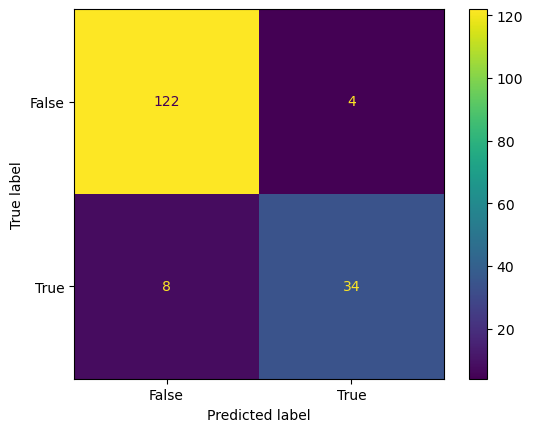

In [39]:
# Get the Confusion Matrix for the predicted and CalEnviroScreen4.0 classifications of EJ Communities
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

When we use all of the variables from CalEnviroScreen4.0 and the additional variables, only four out of 168 census tracts are classified as Environmental Justice communities by the RandomForest Classifier which are not classified as Environmental Justice communities under CalEnviroScreen4.0 for communities at or above the 75th percentile for their overall scores. The model also fails to classify 8 census tracts as Environmental Justice communities which are classified as disadvantaged by CalEnviroScreen4.0.  

Text(0, 0.5, 'Mean decrease in impurity')

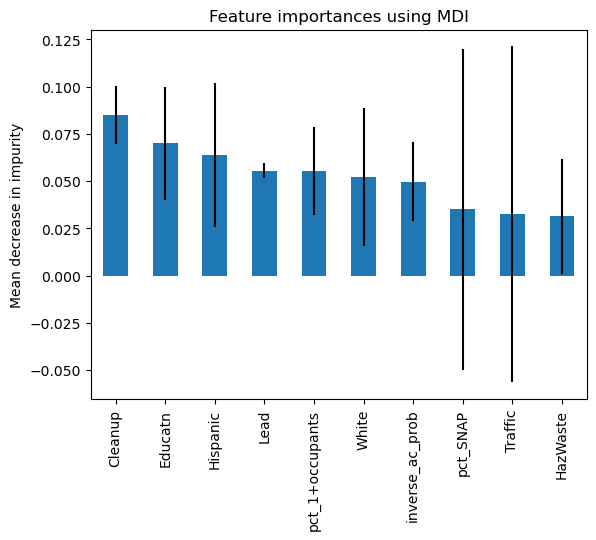

In [57]:
import matplotlib.pyplot as plt
# Determine which variables are most important for predicting EJ Communities
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# Plot the top 10 variables and their importances
fig, ax = plt.subplots()
forest_importances[:10].plot.bar(yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

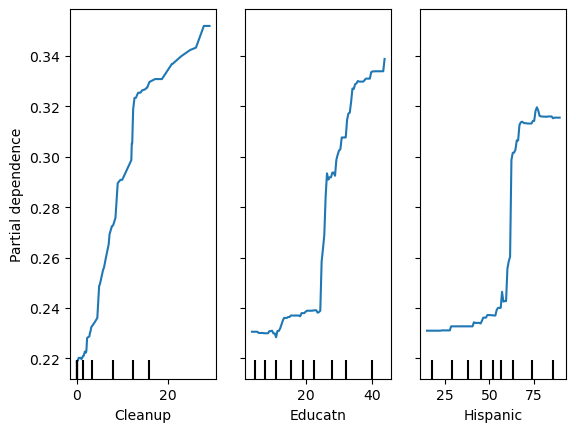

In [64]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, X_test,
                                       forest_importances.index[:3])